In [1]:
# TODO: add crop for log_sigma and for abs diff for FVC
# TODO: add normalization for data
# TODO: ...

In [91]:
%config Completer.use_jedi = False

import os
import platform
from collections import namedtuple
import time

from tqdm.notebook import tqdm
import tabulate

import pandas as pd
import numpy as np
import sparse

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import _Loss
from torch.optim.lr_scheduler import _LRScheduler
# from torchvision import transforms
# from torchsummary import summary
# from efficientnet_pytorch_3d import EfficientNet3D
from my_efficientnet_pytorch_3d import EfficientNet3D
import torchio

from utils import CTDataset


########################

RUNNING_IN_KAGGLE = 'linux' in platform.platform().lower()
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/" if RUNNING_IN_KAGGLE else 'data/'
PROCESSED_PATH = 'FIX IT!' if RUNNING_IN_KAGGLE else 'data/processed-data/'  # TODO: fix this line

dtype = torch.float32
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device = torch.device(device)

In [6]:
class SqueezeLayer(nn.Module):
    def forward(self, x):
        return x.squeeze()


class FeatureExtractor(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, x):
        return self.net.extract_features(x.unsqueeze(0).unsqueeze(0))

In [7]:
class VGG(torch.nn.Module):
    _vgg_configurations = {
        'small': [8, 'M', 8, 'M', 16, 'M', 16, 'M'],  # , 64, 'M', 64, 'M'],  # , 512, 'M', 512, 'M'],
        8: [64, 'M', 128, 'M', 256, 'M', 512, 'M', 512, 'M'],
        11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }

    @staticmethod
    def _make_layers(cfg, batch_norm):
        layers = []
        in_channels = 1
        for v in cfg:
            if v == 'M':
                layers += [torch.nn.MaxPool3d(kernel_size=2, stride=2)]
            else:
                layers += [torch.nn.Conv3d(in_channels, v, kernel_size=3, padding=1)]
                if batch_norm:
                    layers += [torch.nn.BatchNorm3d(v)]
                layers += [torch.nn.ReLU(inplace=True)]
                in_channels = v
        return layers

    def __init__(self, VGG_version, batch_norm):  # num_classes, 
        super().__init__()
        self.VGG_version = VGG_version
        self.batch_norm = batch_norm
#         self.num_classes = num_classes

#         self.layers = torch.nn.ModuleList([
#             # Convolution Layers
#             *make_layers(_vgg_configurations[VGG_version], batch_norm),

#             torch.nn.modules.flatten.Flatten(),

#             # Fully Connected Layers
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Dropout(),
#             torch.nn.Linear(512, 512),
#             torch.nn.ReLU(inplace=True),
#             torch.nn.Linear(512, num_classes),
#         ])
        
        self.net = nn.Sequential(
            *VGG._make_layers(self._vgg_configurations[VGG_version], batch_norm)
        )

        self._initialize_weights()

    def _initialize_weights(self):
#         for module in self.modules():
#             if isinstance(module, torch.nn.Conv3d):
#                 torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
#                 if module.bias is not None:
#                     torch.nn.init.constant_(module.bias, 0)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor):  # , target_layers: Optional[set] = None):
#         intermediate_layers = []
#         for idx, layer in enumerate(self.layers):
#             if target_layers is not None and idx in target_layers:
#                 x.requires_grad_(True)
#                 intermediate_layers.append(x)
#             x = layer(x)
#         if target_layers is not None and len(self.layers) in target_layers:
#             x.requires_grad_(True)
#             intermediate_layers.append(x)

#         if target_layers is not None:
#             return x, intermediate_layers
        return self.net(x)

In [80]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-5, 5)

        if metric:
            abs_diff.clamp_max_(1000)
            log_sigma.clamp_(-np.log(70), np.log(70))  # TODO: min bound is strange??

#         log_sigma.clamp_min_(-5)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [81]:
class OSICNet(nn.Module):
    def __init__(self, dtype, device, efficient_net_model_number, hidden_size, dropout_rate):  # , output_size
        super().__init__()

        self.dtype = dtype
        self.device = device

        self.CT_features_extractor = nn.Sequential(
#             FeatureExtractor(
#                 EfficientNet3D.from_name(
#                     f'efficientnet-b{efficient_net_model_number}', override_params={'num_classes': 1}, in_channels=1
#                 )
#             ),
            VGG('small', True),
            nn.AdaptiveAvgPool3d(1),
            SqueezeLayer()
        )

        self.predictor = nn.Sequential(
            nn.Linear(16, hidden_size),  # 16 +   # 1294
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),  # nn.Tanh(),  # 
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 2)  # FVC & log_sigma  # output_size
        )

        self._initialize_weights()

        self.CT_features_extractor.to(self.device)
        self.predictor.to(self.device)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv3d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.kernel_size[2] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, torch.nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

        
#     def forward(self, data):
#         mean_dataset, std_dataset = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - mean_dataset) / std_dataset
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = lungs_features  # torch.cat([lungs_features, table_features])

#             pred_numbers = self.predictor(X).cpu()
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)

#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)

    def _normalize_data(self, data):
        percents, weeks, FVCs, features, masks, images = data

        lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
        lungs = -1000 * (1.0 - masks) + masks * images
        lungs = (lungs - lungs_mean) / lungs_std
        lungs = lungs.type(self.dtype)
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

        percents_mean, percents_std = 77.6726, 19.8233
        weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

        percents = (percents - percents_mean) / percents_std
        weeks = (weeks - weeks_mean) / weeks_std
        FVCs = (FVCs - FVCs_mean) / FVCs_std
#         features = (features - other_ftrs_mean) / other_ftrs_std
        features = features.type(self.dtype)
#         masks = lungs
#         images = None

        return percents, weeks, FVCs, features, lungs, images

    def forward(self, data):
        percents, weeks, FVCs, features, lungs, images = self._normalize_data(data)
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         OSICNet._normalize_data(data)

#         lungs = data.masks

        ###############################
#         lungs = lungs.unsqueeze(0).to(self.device)  # TODO: uncomment
#         lungs_features = self.CT_features_extractor(lungs)
        ###############################
        
#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

#         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
#         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
#         weeks[:, 3] = 1
#         weeks[:, 2] = data_weeks
#         weeks[:, 1] = data_weeks ** 2
#         weeks[:, 0] = data_weeks ** 3

#         agg_loss = 0
        all_preds = []
        for base_percent, base_week, base_FVC in zip(percents, weeks, FVCs):
            table_features = torch.cat([
                torch.tensor([base_percent]),
                torch.tensor([base_week]),
                torch.tensor([base_FVC]),
                features
            ]).to(self.device)  # torch.tensor([week]),

            all_features = torch.cat([table_features])  # lungs_features,  # TODO: uncomment

            X = torch.cat([all_features.repeat(weeks.shape[0], 1), weeks.unsqueeze(1).to(self.device)], dim=1)

            preds = self.predictor(X).cpu()
            
#             for week in weeks:
#                 table_features = torch.cat([torch.tensor([base_week]), torch.tensor([base_FVC]),
#                                             torch.tensor([week]), features]).to(self.device)
# #                                            dtype=self.dtype, device=self.device)
#                 X = torch.cat([lungs_features, table_features])  # .to(self.device)  # lungs_features

#                 pred_numbers = self.predictor(X).cpu()
#                 preds = self.predictor(X).cpu()
            all_preds.append(preds)
#             coefs = pred_numbers[:4]
#             log_sigma = pred_numbers[4]

#             FVC_preds = (weeks * coefs).sum(dim=1)
#             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
#             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

#         return agg_loss / len(data.weeks)
        return all_preds

#     def forward(self, data):
#         lungs_mean, lungs_std = -971.4692260919278, 117.84143467421829
#         lungs = -1000 * (1.0 - data.masks) + data.masks * data.images
#         lungs = (lungs - lungs_mean) / lungs_std
#         lungs = torch.tensor(lungs, dtype=self.dtype, device=self.device)
#         lungs_features = self.CT_features_extractor(lungs)

#         weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
#         FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
#         other_ftrs_mean = np.array([
#             2.76561876e+00,  1.42373805e+00,  1.25608294e+00,  1.33766080e+02,
#             -5.23857955e+02, -1.24154545e+03,  6.72613636e+01,  7.89772727e-01,
#             2.10227273e-01,  6.70454545e-01,  2.78409091e-01,  5.11363636e-02
#         ])
#         other_ftrs_std = np.array([
#             2.34777445e+00, 1.47563586e-01, 9.90841780e-01, 5.85989667e+01,
#             1.92059435e+02, 8.48268563e+02, 7.06784382e+00, 4.07469958e-01,
#             4.07469958e-01, 4.70048134e-01, 4.48215873e-01, 2.20275818e-01
#         ])

#         data._replace(weeks = (np.array(data.weeks) - weeks_mean) / weeks_std)
#         data._replace(fvcs = (np.array(data.fvcs) - FVCs_mean) / FVCs_std)
#         data._replace(features = (np.array(data.features) - other_ftrs_mean) / other_ftrs_std)

# #         data_weeks = torch.tensor(data.weeks, dtype=self.dtype)
# #         weeks = torch.empty(len(data.weeks), 4, dtype=self.dtype)
# #         weeks[:, 3] = 1
# #         weeks[:, 2] = data_weeks
# #         weeks[:, 1] = data_weeks ** 2
# #         weeks[:, 0] = data_weeks ** 3

# #         agg_loss = 0
#         all_preds = []
#         for week, FVC in zip(data.weeks, data.fvcs):
#             table_features = torch.tensor(np.r_[week, FVC, data.features], dtype=self.dtype, device=self.device)
#             X = torch.cat([lungs_features, table_features])  # lungs_features

#             pred_numbers = self.predictor(X).cpu()
#             all_preds.append(pred_numbers)
# #             coefs = pred_numbers[:4]
# #             log_sigma = pred_numbers[4]

# #             FVC_preds = (weeks * coefs).sum(dim=1)
# #             FVC_true = torch.tensor(data.fvcs, dtype=self.dtype)
            
# #             agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)

# #         return agg_loss / len(data.weeks)
#         return all_preds


class LinearDecayLR(_LRScheduler):
    def __init__(self, optimizer, start_epoch, stop_epoch, start_lr, stop_lr, last_epoch=-1):
        self.optimizer = optimizer

        self.start_epoch = start_epoch
        self.stop_epoch = stop_epoch

        self.start_lr = start_lr
        self.stop_lr = stop_lr

        self.last_epoch = last_epoch

        super().__init__(optimizer, last_epoch)

    def get_lr(self) -> list:
        if self.last_epoch < self.start_epoch:
            new_lr = self.start_lr
        elif self.last_epoch > self.stop_epoch:
            new_lr = self.stop_lr
        else:
            new_lr = self.start_lr + (
                (self.stop_lr - self.start_lr) *
                (self.last_epoch - self.start_epoch) /
                (self.stop_epoch - self.start_epoch)
            )
        return [new_lr for _ in self.optimizer.param_groups]

In [82]:
transforms = torchio.transforms.Compose([
    torchio.transforms.RandomAffine(
        degrees=(10, 10),
        translation=(-10, -10),
        isotropic=False,
        default_pad_value='minimum',
        image_interpolation='linear',
    ),
#     torchio.transforms.RandomElasticDeformation(
#         max_displacement=3.0
#     )
])

In [109]:
train_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True,
    transform=transforms,
    test_size=0.25,
    padding_mode='edge',
    random_state=42,
    pad_global=False,
)

test_dataset = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=False,
    transform=transforms,
    test_size=0.25,
    padding_mode=None,  # 'edge',
    random_state=42,
    pad_global=False,
)

In [19]:
# dl = DataLoader(train_dataset, batch_size=1, num_workers=4)
# # next(iter(dl))

# from tqdm.notebook import tqdm

# # %%time

# # for _ in tqdm(dl):
# #     pass

# # %%time

# # for _ in train_dataset:
# #     pass

# # # _

In [27]:
model = OSICNet(dtype=dtype, device=device, efficient_net_model_number=0, hidden_size=100, dropout_rate=0)  # 512, 0.5)
# optimizer = optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)  # , weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # 3e-4
# optimizer = optim.SGD(model.parameters(), lr=1e-3)  # 3e-4


### TMP ###
# optimizer = optim.SGD(model.parameters(), lr=1e-9, momentum=0, weight_decay=0)  # 0.9, 5e-4)
# lr_scheduler = LinearDecayLR(optimizer, )



# for g in optimizer.param_groups:
#     g['lr'] /= 10



# from torchsummary import summary
# summary(model.CT_features_extractor[0].net)

# mmm = FeatureExtractor(
#     EfficientNet3D.from_name(
#         f'efficientnet-b{0}', override_params={'num_classes': 1}, in_channels=1
#     )
# )

# summary(mmm)

# preds = model(train_dataset[0])
# preds


# torch.cat([torch.tensor([1]), torch.tensor([2]), torch.tensor([3]), torch.tensor([1, 2, 3])])

# lungs_features.shape

# preds
# preds[0]

In [89]:
from torch.utils.tensorboard import SummaryWriter

log_writer = SummaryWriter(log_dir='logs/')

In [102]:
def print_results(mode, writer, epoch, cur_iter, loss, metric, metric_last_3, start_time,
                  cur_start_time, cur_end_time, log_sigmas):
    writer.add_scalar(f'loss/{mode}', loss.item(), epoch)
    writer.add_scalar(f'metric/{mode}', metric, epoch)
    writer.add_scalar(f'metric (last 3)/{mode}', metric_last_3, epoch)
    writer.add_scalar(f'log sigma/{mode}', log_sigmas.detach().mean().item(), epoch)

    columns = [
        'Epoch', 
        'Iter', 
        'Loss', 
        'Metric', 
        'Metric (last 3)', 
        'Cur iter time', 
        'Elapsed time', 
        'Log sigma'
    ]

    values = [
        f'{epoch + 1}',
        f'{cur_iter + 1}',
        f'{loss.item():0.6f}',
        f'{metric:0.6f}',
        f'{metric_last_3:0.6f}',
        f'{cur_end_time - cur_start_time:0.1f} sec',
        f'{cur_end_time - start_time:0.1f} sec',
        f'{log_sigmas.detach().mean().item():0.3f}'
    ]
    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='8.4f')
    if cur_iter % 40 == 0:
        table = table.split('\n')
        table = '\n'.join([table[1]] + table)
    else:
        table = table.split('\n')[2]
    print(table)

In [101]:
MAX_EPOCHS = 10


model.train()

start_time = time.time()
for epoch in tqdm(range(MAX_EPOCHS)):
    for cur_iter, data in enumerate(train_dataset):  # tqdm(, desc='Iteration over dataset'):
#         if cur_iter >= 1:
#             break
        cur_start_time = time.time()

        optimizer.zero_grad()

#         loss = model(data)
        percents, weeks, FVC_true, features, lungs, images = data
        FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

        all_preds = model(data)

        agg_loss = 0
        agg_metric = 0
        agg_metric_last_3 = 0
        for preds in all_preds:  # zip(, [None, ]):  # TODO: REMOVE!
            FVC_preds, log_sigmas = preds.transpose(0, 1)
            FVC_preds = FVC_preds * FVCs_std + FVCs_mean

            agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)
#             agg_loss += nn.MSELoss()(FVC_true, FVC_preds).pow(0.5)  # , log_sigmas)
            with torch.no_grad():
                agg_metric += LaplaceLoss()(FVC_true, FVC_preds, torch.tensor(5.), metric=True).item()  # log_sigmas
                agg_metric_last_3 += LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:], torch.tensor(5.), metric=True).item()
        loss = agg_loss / weeks.shape[0]
        metric = agg_metric / weeks.shape[0]
        metric_last_3 = agg_metric_last_3 / weeks.shape[0]

        loss.backward()
        optimizer.step()

        cur_end_time = time.time()

        print_results('train', log_writer, epoch, cur_iter, loss, metric, metric_last_3,
                      start_time, cur_start_time, cur_end_time, log_sigmas)

#         print(
#             f'Epoch {epoch + 1:3d}, '
#             f'iter {cur_iter + 1:4d}, '
#             f'loss {loss.item():12.6f}, '
#             f'metric {metric:12.6f}, '
#             f'metric (last 3) {metric_last_3:12.6f}, '
#             f'cur iter time {cur_end_time - cur_start_time:6.1f} sec, '
#             f'elapsed time {cur_end_time - start_time:6.1f} sec, '
#             f'log sigma {log_sigmas.detach().mean().item()}'
#         )

-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      1       1    7.5008   10.3879            11.3841  0.1 sec          1.2 sec              5.0000
      1       2    6.8031    8.9087            11.8248  0.1 sec          2.3 sec              5.0000
      1       3    9.3029   14.2089            15.0897  0.1 sec          3.4 sec              5.0000
      1       4    6.6835    8.6551             8.2377  0.1 sec          4.5 sec              5.0000
      1       5    5.4640    6.0695             5.4016  0.1 sec          5.7 sec              5.0000
      1       6    6.2835    7.8072             6.7732  0.1 sec          6.8 sec              5.0000
      1       7    6.0816    7.3791             7.8802  0.1 sec          7.9 sec           

      1      77    5.3321    5.7900             6.0906  0.1 sec          89.5 sec             5.0000
      1      78   11.5386   18.4509            16.7002  0.1 sec          90.7 sec             5.0000
      1      79    6.5211    8.5833            10.5330  0.1 sec          91.9 sec             5.0000
      1      80    7.9249   11.2873            10.2916  0.1 sec          93.1 sec             5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      1      81    5.7056    6.5819             7.1210  0.1 sec          94.3 sec             5.0000
      1      82   10.0465   15.7854            16.5251  0.1 sec          95.4 sec             5.0000
      1      83    6.7631    8.7924            13.3872  0.1 sec          96.5 sec          

      2      18    9.0425   13.4206            15.8849  0.1 sec          173.7 sec            5.0000
      2      19    5.5399    6.2306             6.7181  0.1 sec          174.9 sec            5.0000
      2      20    8.5781   12.6721            12.8208  0.1 sec          176.0 sec            5.0000
      2      21   11.9798   18.2142            20.2894  0.1 sec          177.2 sec            5.0000
      2      22    5.8662    7.0450             7.1626  0.1 sec          178.3 sec            5.0000
      2      23    5.6302    6.4220             6.8859  0.1 sec          179.5 sec            5.0000
      2      24    7.6113   10.5202             9.4203  0.1 sec          180.7 sec            5.0000
      2      25    7.2312    9.7619            13.0194  0.1 sec          181.9 sec            5.0000
      2      26   11.3107   17.5347            20.0041  0.1 sec          182.9 sec            5.0000
      2      27    6.2830    7.8060             6.0755  0.1 sec          184.1 sec         

      2      94    7.3753    9.9222            11.5594  0.1 sec          262.3 sec            5.0000
      2      95    5.6876    6.5437             7.4098  0.1 sec          263.5 sec            5.0000
      2      96    6.5156    8.2993             8.7777  0.1 sec          264.6 sec            5.0000
      2      97    7.5926   10.5827            10.0937  0.1 sec          265.8 sec            5.0000
      2      98    6.0530    7.3183             7.4318  0.1 sec          266.9 sec            5.0000
      2      99    4.9198    5.0384             6.4580  0.1 sec          268.1 sec            5.0000
      2     100    5.5745    6.3039             5.6753  0.1 sec          269.3 sec            5.0000
      2     101    5.6447    6.4528             6.3795  0.1 sec          270.5 sec            5.0000
      2     102    7.9881   11.4211            10.9247  0.1 sec          271.7 sec            5.0000
      2     103    7.4709   10.3245             8.2435  0.1 sec          272.8 sec         

      3      38    8.0764   11.6084            11.2094  0.1 sec          350.0 sec            5.0000
      3      39    6.8958    9.2279             9.0347  0.1 sec          351.1 sec            5.0000
      3      40    6.4949    8.2552             7.8474  0.1 sec          352.3 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      3      41    5.5898    6.3363             6.3004  0.1 sec          353.5 sec            5.0000
      3      42    5.5667    6.4098             8.2217  0.1 sec          354.6 sec            5.0000
      3      43    8.2642   11.1676            11.8531  0.1 sec          355.8 sec            5.0000
      3      44    5.2457    5.7293             7.1388  0.1 sec          357.0 sec         

      3     114    7.6782   10.7640             8.6601  0.1 sec          438.1 sec            5.0000
      3     115    6.2189    7.6702            10.8948  0.1 sec          439.2 sec            5.0000
      3     116    5.7781    6.7356             8.3188  0.1 sec          440.3 sec            5.0000
      3     117    6.3492    7.9464            11.0203  0.1 sec          441.5 sec            5.0000
      3     118    5.4760    6.2177             9.2752  0.1 sec          442.6 sec            5.0000
      3     119    5.3763    5.8837             7.4101  0.1 sec          443.7 sec            5.0000
      3     120    5.3315    5.7887             5.0990  0.1 sec          444.8 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  --

      4      55    6.0383    7.2872             7.2709  0.1 sec          522.4 sec            5.0000
      4      56    5.9803    7.1643             9.1759  0.1 sec          523.5 sec            5.0000
      4      57    5.6606    6.4864             6.8643  0.1 sec          524.7 sec            5.0000
      4      58    7.0250    9.3792            10.3767  0.1 sec          525.8 sec            5.0000
      4      59    9.3616   14.3333            14.3476  0.1 sec          527.0 sec            5.0000
      4      60    5.5412    6.2332             6.2319  0.1 sec          528.1 sec            5.0000
      4      61    6.2236    7.6801             6.2935  0.1 sec          529.3 sec            5.0000
      4      62    5.5680    6.2901             5.7491  0.1 sec          530.5 sec            5.0000
      4      63    7.1965    9.7427            13.4003  0.1 sec          531.6 sec            5.0000
      4      64    5.7016    6.5733             8.1827  0.1 sec          532.8 sec         

      4     131    6.9383    9.1954             7.8423  0.1 sec          610.4 sec            5.0000
      4     132    5.4692    6.2031             6.4483  0.1 sec          611.6 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      5       1    6.1264    7.4740             8.7555  0.1 sec          612.8 sec            5.0000
      5       2    7.2123    9.7569            12.2589  0.1 sec          614.0 sec            5.0000
      5       3    7.7246   10.8625            10.7548  0.1 sec          615.1 sec            5.0000
      5       4    5.1858    5.4798             5.8174  0.1 sec          616.2 sec            5.0000
      5       5    6.2735    7.7859             7.9863  0.1 sec          617.4 sec         

      5      75    5.9181    7.0325             8.2740  0.1 sec          700.0 sec            5.0000
      5      76    6.1860    7.8728             9.6854  0.1 sec          701.2 sec            5.0000
      5      77    5.5353    6.2207             6.6810  0.1 sec          702.3 sec            5.0000
      5      78    5.8964    6.9863             6.2322  0.1 sec          703.5 sec            5.0000
      5      79    5.2654    5.9209             6.6393  0.1 sec          704.7 sec            5.0000
      5      80    6.1348    7.4918             5.8466  0.1 sec          705.8 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      5      81    5.5939    6.3451             7.1220  0.1 sec          706.9 sec         

      6      16    5.7756    6.7303             7.7715  0.1 sec          783.7 sec            5.0000
      6      17    5.7396    6.6539             6.6142  0.1 sec          784.9 sec            5.0000
      6      18    5.8418    6.9931             6.8837  0.1 sec          786.1 sec            5.0000
      6      19    5.1926    5.4943             4.9102  0.1 sec          787.3 sec            5.0000
      6      20    4.7859    4.6319             5.0986  0.1 sec          788.5 sec            5.0000
      6      21    5.3210    5.7665             7.1552  0.1 sec          789.6 sec            5.0000
      6      22    5.6323    6.5491             6.9961  0.1 sec          790.8 sec            5.0000
      6      23    4.8914    4.8555             5.4659  0.1 sec          792.0 sec            5.0000
      6      24    5.1939    5.3949             6.1735  0.1 sec          793.3 sec            5.0000
      6      25    6.3270    7.8994            10.1703  0.1 sec          794.5 sec         

      6      92    5.3028    5.7277             7.3097  0.1 sec          872.3 sec            5.0000
      6      93    6.4770    8.3399            10.0955  0.1 sec          873.5 sec            5.0000
      6      94    7.5282    9.9571            11.4796  0.1 sec          874.7 sec            5.0000
      6      95    5.5972    6.3520             7.2475  0.1 sec          875.8 sec            5.0000
      6      96    5.5061    6.1589             6.8335  0.1 sec          877.0 sec            5.0000
      6      97    6.0336    7.2772             7.4070  0.1 sec          878.1 sec            5.0000
      6      98    5.3451    5.8175             5.5748  0.1 sec          879.2 sec            5.0000
      6      99    4.9999    5.2081             6.7604  0.1 sec          880.3 sec            5.0000
      6     100    5.4487    6.0371             5.5299  0.1 sec          881.4 sec            5.0000
      6     101    5.2135    5.5386             4.6328  0.1 sec          882.6 sec         

      7      36    6.2172    7.6666             5.9887  0.1 sec          960.8 sec            5.0000
      7      37    5.6955    6.5604             6.8156  0.1 sec          962.0 sec            5.0000
      7      38    7.2969    9.9556             9.4436  0.1 sec          963.2 sec            5.0000
      7      39    7.1557    9.7790             8.7490  0.1 sec          964.3 sec            5.0000
      7      40    6.7702    8.8390             9.1391  0.1 sec          965.5 sec            5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      7      41    5.6194    6.3991             6.2522  0.1 sec          966.8 sec            5.0000
      7      42    5.0574    5.3300             4.6987  0.1 sec          967.9 sec         

      7     112    5.4889    6.1223             5.8121  0.1 sec          1049.2 sec           5.0000
      7     113    6.9713    9.2346            10.2155  0.1 sec          1050.3 sec           5.0000
      7     114    5.2709    5.6601             6.3157  0.1 sec          1051.5 sec           5.0000
      7     115    5.5574    6.2676             7.3907  0.1 sec          1052.6 sec           5.0000
      7     116    5.4838    6.1115             7.2565  0.1 sec          1053.7 sec           5.0000
      7     117    6.3296    7.9048            10.8957  0.1 sec          1054.9 sec           5.0000
      7     118    5.6174    6.5173             9.6146  0.1 sec          1056.0 sec           5.0000
      7     119    5.9366    7.0716             8.8494  0.1 sec          1057.1 sec           5.0000
      7     120    5.2867    5.6936             5.0664  0.1 sec          1058.2 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  --

      8      53    6.6997    8.6895             8.0833  0.1 sec          1134.6 sec           5.0000
      8      54    5.7071    6.7077             7.3180  0.1 sec          1135.8 sec           5.0000
      8      55    5.4828    6.1095             5.7956  0.1 sec          1136.9 sec           5.0000
      8      56    5.5092    6.1655             8.6296  0.1 sec          1138.1 sec           5.0000
      8      57    5.7219    6.6165             7.0734  0.1 sec          1139.3 sec           5.0000
      8      58    5.1287    5.3586             5.2336  0.1 sec          1140.5 sec           5.0000
      8      59    6.5796    8.4350             8.6156  0.1 sec          1141.7 sec           5.0000
      8      60    4.8580    4.7848             4.3669  0.1 sec          1142.8 sec           5.0000
      8      61    6.0890    7.3948             6.1008  0.1 sec          1143.9 sec           5.0000
      8      62    5.4603    6.0618             6.5658  0.1 sec          1145.1 sec        

      8     129    5.9956    7.1967             7.6682  0.1 sec          1222.1 sec           5.0000
      8     130    7.9638   10.9124            12.8378  0.1 sec          1223.3 sec           5.0000
      8     131    6.6901    8.6692             7.6110  0.1 sec          1224.5 sec           5.0000
      8     132    5.0906    5.4005             5.2540  0.1 sec          1225.6 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
      9       1    5.8259    6.8369             7.1157  0.1 sec          1226.8 sec           5.0000
      9       2    6.9503    9.2208            11.2336  0.1 sec          1227.9 sec           5.0000
      9       3    5.7336    6.6413             7.1999  0.1 sec          1229.0 sec        

      9      73    5.2675    5.5510             5.5836  0.1 sec          1310.7 sec           5.0000
      9      74    5.5041    6.0524             5.6205  0.1 sec          1311.9 sec           5.0000
      9      75    6.0271    7.2635             8.4338  0.1 sec          1313.1 sec           5.0000
      9      76    6.2850    8.0826            10.6484  0.1 sec          1314.2 sec           5.0000
      9      77    5.8437    6.8747             8.1323  0.1 sec          1315.3 sec           5.0000
      9      78    5.5098    6.1666             5.8940  0.1 sec          1316.5 sec           5.0000
      9      79    5.3451    6.0899             6.7606  0.1 sec          1317.7 sec           5.0000
      9      80    6.4497    8.1594             6.0740  0.1 sec          1318.8 sec           5.0000
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      

     10      14    6.2343    7.8252             7.0313  0.1 sec          1394.7 sec           5.0000
     10      15    6.3352    7.9168             6.4208  0.1 sec          1395.9 sec           5.0000
     10      16    5.4782    6.0998             6.5677  0.1 sec          1397.1 sec           5.0000
     10      17    6.0974    7.4126             7.6852  0.1 sec          1398.3 sec           5.0000
     10      18    5.8231    6.9534             6.4806  0.1 sec          1399.4 sec           5.0000
     10      19    5.0165    5.1209             4.9259  0.1 sec          1400.7 sec           5.0000
     10      20    4.9636    5.0087             5.0833  0.1 sec          1401.8 sec           5.0000
     10      21    6.0245    7.2579             4.8179  0.1 sec          1402.9 sec           5.0000
     10      22    5.8275    6.9628             7.5969  0.1 sec          1404.0 sec           5.0000
     10      23    5.2100    5.5310             6.4534  0.1 sec          1405.2 sec        

     10      90    5.4987    6.1432             5.9754  0.1 sec          1483.2 sec           5.0000
     10      91    5.2865    5.8158             5.7276  0.1 sec          1484.3 sec           5.0000
     10      92    5.3610    5.8512             6.3108  0.1 sec          1485.5 sec           5.0000
     10      93    6.5599    8.5157            10.4067  0.1 sec          1486.6 sec           5.0000
     10      94    7.9840   10.4034            11.3262  0.1 sec          1487.9 sec           5.0000
     10      95    5.8360    6.8583             7.4122  0.1 sec          1489.1 sec           5.0000
     10      96    5.5976    6.3530             7.4615  0.1 sec          1490.5 sec           5.0000
     10      97    4.9650    5.0117             5.4072  0.4 sec          1492.1 sec           5.0000
     10      98    5.3032    5.7287             5.2253  0.2 sec          1493.5 sec           5.0000
     10      99    4.9210    5.0410             5.9517  0.2 sec          1495.0 sec        

## Test

In [110]:
model.eval()

start_time = time.time()

sum_loss = 0
sum_metric = 0
sum_metric_last_3 = 0
sum_metric_by_first_week = 0
sum_metric_last_3_by_first_week = 0

for cur_iter, data in enumerate(test_dataset):
    cur_start_time = time.time()

    percents, weeks, FVC_true, features, lungs, images = data
    FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238
    with torch.no_grad():
        all_preds = model(data)

    agg_loss = 0
    agg_metric = 0
    agg_metric_last_3 = 0

    for preds in all_preds:
        FVC_preds, log_sigmas = preds.transpose(0, 1)
        FVC_preds = FVC_preds * FVCs_std + FVCs_mean

        agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)
#             agg_loss += nn.MSELoss()(FVC_true, FVC_preds).pow(0.5)  # , log_sigmas)
#         with torch.no_grad():
        agg_metric += LaplaceLoss()(FVC_true, FVC_preds, log_sigmas, metric=True).item()  # log_sigmas
        agg_metric_last_3 += LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:], log_sigmas[-3:], metric=True).item()
    loss = agg_loss / weeks.shape[0]
    metric = agg_metric / weeks.shape[0]
    metric_last_3 = agg_metric_last_3 / weeks.shape[0]

    FVC_preds, log_sigmas = all_preds[0].transpose(0, 1)
    FVC_preds = FVC_preds * FVCs_std + FVCs_mean
    metric_by_first_week = LaplaceLoss()(FVC_true, FVC_preds, log_sigmas, metric=True).item()
    metric_last_3_by_first_week = LaplaceLoss()(FVC_true[-3:], FVC_preds[-3:], log_sigmas[-3:], metric=True).item()

    sum_loss += loss
    sum_metric += metric
    sum_metric_last_3 += metric_last_3
    sum_metric_by_first_week += metric_by_first_week
    sum_metric_last_3_by_first_week += metric_last_3_by_first_week

    cur_end_time = time.time()

    print_results('test', log_writer, epoch, cur_iter, loss, metric, metric_last_3,
                  start_time, cur_start_time, cur_end_time, log_sigmas)


    print(
        'loss', sum_loss / (cur_iter + 1),
        'metric', sum_metric / (cur_iter + 1),
        'metric_last_3', sum_metric_last_3 / (cur_iter + 1),
        'metric_by_first_week', sum_metric_by_first_week / (cur_iter + 1),
        'metric_last_3_by_first_week', sum_metric_last_3_by_first_week / (cur_iter + 1)
    )

#         print(
#             f'Epoch {epoch + 1:3d}, '
#             f'iter {cur_iter + 1:4d}, '
#             f'loss {loss.item():12.6f}, '
#             f'metric {metric:12.6f}, '
#             f'metric (last 3) {metric_last_3:12.6f}, '
#             f'cur iter time {cur_end_time - cur_start_time:6.1f} sec, '
#             f'elapsed time {cur_end_time - start_time:6.1f} sec, '
#             f'log sigma {log_sigmas.detach().mean().item()}'
#         )

-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
  Epoch    Iter      Loss    Metric    Metric (last 3)  Cur iter time    Elapsed time      Log sigma
-------  ------  --------  --------  -----------------  ---------------  --------------  -----------
     10       1    5.7202    5.3873             5.2042  0.5 sec          1.9 sec              4.2480
loss tensor(5.7202) metric 5.387323803371853 metric_last_3 5.204214043087429 metric_by_first_week 5.753589153289795 metric_last_3_by_first_week 5.813117980957031
     10       2    9.1193   12.5940            15.4620  0.1 sec          3.6 sec              4.2480
loss tensor(7.4198) metric 8.990668568346235 metric_last_3 10.333087179395887 metric_by_first_week 9.80460810661316 metric_last_3_by_first_week 14.233376502990723
     10       3    6.9437    7.9812             9.6980  0.1 sec          5.5 sec              4.2480
loss tensor(7.2611) metric 8.654176734111926 metric_last_3 10.1213762

     10      31    6.8773    7.8406             7.3049  0.1 sec          49.1 sec             4.2480
loss tensor(7.2306) metric 8.58144613611228 metric_last_3 8.823125582997518 metric_by_first_week 8.396107489062894 metric_last_3_by_first_week 9.528011691185736
     10      32    8.8742   11.5666            12.9520  0.1 sec          50.8 sec             4.2480
loss tensor(7.2819) metric 8.674732717706096 metric_last_3 8.952152442725168 metric_by_first_week 8.517435848712921 metric_last_3_by_first_week 9.715100139379501
     10      33    5.8803    5.7266             5.8650  0.1 sec          52.3 sec             4.2480
loss tensor(7.2394) metric 8.585395565945806 metric_last_3 8.85860270649381 metric_by_first_week 8.43679698308309 metric_last_3_by_first_week 9.60078477859497
     10      34    7.2218    8.5708             9.5377  0.1 sec          53.9 sec             4.2480
loss tensor(7.2389) metric 8.584966239007581 metric_last_3 8.878574766815543 metric_by_first_week 8.48192550154293

In [42]:
for g in optimizer.param_groups:
    g['lr'] *= 2

In [35]:
np.sqrt(2) * 1000 / 70 + np.log(70) + np.log(2) / 2

24.79811972337355

In [55]:
FVC_true

tensor([2390, 2390, 2322, 2305, 2116, 2036, 2062, 1865, 1928, 1901, 2322])

In [56]:
all_preds[0][:, 0] * FVCs_std + FVCs_mean

tensor([2279.0103, 2140.1113, 2132.3945, 2124.6780, 2116.9614, 2109.2446,
        2086.0950, 2039.7952, 1989.6372, 1927.9043, 1715.6973],
       grad_fn=<AddBackward0>)

In [64]:
abs_diff = (all_preds[0][:, 0] * FVCs_std + FVCs_mean - FVC_true).abs()
losses = np.sqrt(2) * abs_diff / 70 + np.log(70) + np.log(2) / 2

In [66]:
losses.mean()

tensor(7.7151, grad_fn=<MeanBackward0>)

In [77]:
class LaplaceLoss(nn.Module):  # _Loss):
    def forward(self, y_true, preds, log_sigma, metric=False):
        abs_diff = (y_true - preds).abs()

        log_sigma.clamp_(-5, 5)

        if metric:
            print('HERE')
            abs_diff.clamp_max_(1000)
            print(log_sigma)
            log_sigma.clamp_(-np.log(70), np.log(70))  # TODO: min bound is strange??
            print(log_sigma)

        print(log_sigma)
#         log_sigma.clamp_min_(-5)

        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [79]:
log_sigmas.clamp()

tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)

In [69]:
np.log(70)

4.248495242049359

In [68]:
log_sigmas

tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)

In [71]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, torch.tensor(np.log(70)), True)

tensor(4.2485)


tensor(7.7151, grad_fn=<MeanBackward0>)

In [78]:
LaplaceLoss()(FVC_true, all_preds[0][:, 0] * FVCs_std + FVCs_mean, log_sigmas, True)

HERE
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)
tensor([4.7567, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000, 5.0000,
        5.0000, 5.0000], grad_fn=<AsStridedBackward>)


tensor(6.8225, grad_fn=<MeanBackward0>)

In [33]:
LaplaceLoss()(FVC_true, FVC_preds, log_sigmas)

tensor(25.7638, grad_fn=<MeanBackward0>)

In [34]:
LaplaceLoss()(FVC_true, FVC_preds[0], log_sigmas)

tensor(25.7757, grad_fn=<MeanBackward0>)

In [26]:
coefs.grad

NameError: name 'coefs' is not defined

In [ ]:
weeks_mean ** 3, weeks_mean ** 2, weeks_mean, 1

In [9]:
class LaplaceLossTMP(_Loss):
    def forward(self, y_true, preds, log_sigma):
        abs_diff = (y_true - preds).abs()
#         abs_diff.clamp_max_(1_000)
        log_sigma.clamp_(-5, 5)  # -np.log(70), np.log(70)
#         log_sigma.clamp_min_(-5)
        losses = np.sqrt(2) * abs_diff / log_sigma.exp() + log_sigma + np.log(2) / 2
        return losses.mean()

In [10]:
np.exp(-0.4516299068927765)

0.6365897236027999

In [ ]:
# data = train_dataset[0]


# weeks_mean, weeks_std = 31.861846352485475, 23.240045178171002
# FVCs_mean, FVCs_std = 2690.479018721756, 832.5021066817238

# data_weeks = torch.tensor(data.weeks, dtype=dtype)
# data_weeks = (data_weeks - weeks_mean) / weeks_std
# weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
# weeks[:, 0] = 0 * data_weeks ** 3  # TODO: remove
# weeks[:, 1] = 0 * data_weeks ** 2  # TODO: remove
# weeks[:, 2] = data_weeks
# weeks[:, 3] = 1

# all_preds = model(data)

In [17]:
import matplotlib.pyplot as plt

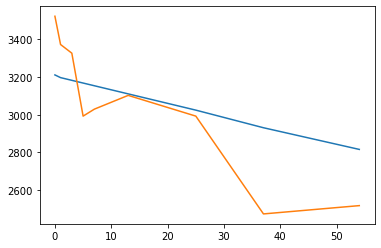

In [35]:
plt.plot(data.weeks, FVC_preds.detach().cpu().numpy())

plt.plot(data.weeks, FVC_true.cpu().numpy())

In [32]:
agg_loss = 0
for FVC, preds in zip(data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]
#             print(log_sigma.item())

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_preds = FVC_preds * FVCs_std + FVCs_mean + 1000 - 200
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLossTMP()(FVC_true, FVC_preds, torch.tensor(np.log(70)))
loss = agg_loss / len(data.weeks)

In [33]:
loss

tensor(8.7861, grad_fn=<DivBackward0>)

In [ ]:
log_sigma.item()

In [24]:
from torchsummary import summary

In [26]:
# summary(model.CT_features_extractor[0].net)

In [ ]:
for name, p in model.named_parameters():
    print(f'{name[20:]:50} : {p.data.min().item():15.3e}, {p.data.max().item():15.3e}')

In [13]:
all_preds = model(train_dataset[2])

In [14]:
all_preds

[tensor([-0.0239,  0.0427, -0.0162,  0.0765, -0.0407], grad_fn=<CopyBackwards>),
 tensor([-0.0596,  0.0999,  0.0310,  0.0311, -0.0328], grad_fn=<CopyBackwards>),
 tensor([-0.0534,  0.0610,  0.0263,  0.1096, -0.0509], grad_fn=<CopyBackwards>),
 tensor([-0.0468, -0.0004,  0.0322,  0.0902, -0.0749], grad_fn=<CopyBackwards>),
 tensor([-0.0137,  0.0090,  0.0003,  0.0589, -0.0920], grad_fn=<CopyBackwards>),
 tensor([-0.0302,  0.0220,  0.0029,  0.1146, -0.0387], grad_fn=<CopyBackwards>),
 tensor([-0.0218,  0.0516, -0.0411,  0.0951,  0.0158], grad_fn=<CopyBackwards>),
 tensor([-0.0205,  0.0779, -0.0219,  0.1012, -0.0544], grad_fn=<CopyBackwards>),
 tensor([ 0.0394,  0.0843, -0.0223,  0.0686, -0.0343], grad_fn=<CopyBackwards>)]

In [16]:
data = train_dataset[2]
data_weeks = torch.tensor(data.weeks, dtype=dtype)
weeks = torch.empty(len(data.weeks), 4, dtype=dtype)
weeks[:, 0] = data_weeks ** 3
weeks[:, 1] = data_weeks ** 2
weeks[:, 2] = data_weeks
weeks[:, 3] = 1

# all_preds = model(data)

agg_loss = 0
for week, FVC, preds in zip(data.weeks, data.fvcs, all_preds):
    coefs = preds[:4]
    log_sigma = preds[4]

    FVC_preds = (weeks * coefs).sum(dim=1)
    FVC_true = torch.tensor(data.fvcs, dtype=dtype)

    agg_loss += LaplaceLoss()(FVC_true, FVC_preds, log_sigma)
loss = agg_loss / len(data.weeks)

In [17]:
loss

tensor(4912.0527, grad_fn=<DivBackward0>)

In [18]:
loss.backward()

In [25]:
for name, p in model.named_parameters():
    if p.requires_grad:
        if p.grad is None:
            print(f'Has grad but it is None: {name[20:]:50}')
        else:
            print(f'{name[20:]:50} : {p.grad.data.cpu().min().item():15.3e}, {p.grad.data.cpu().max().item():15.3e}')
    else:
        print(f'No grad: {name[20:]:50}')

RuntimeError: CUDA error: unspecified launch failure

In [12]:
for i in range(len(train_dataset)):
    print(i, train_dataset[i].images.shape)

In [4]:
dataset_all = CTDataset(
    f'{PROCESSED_PATH}/train',
    f'{IMAGE_PATH}/train.csv',
    train=True, test_size=0.0, random_state=42
)

images = [-1000 * (1.0 - dataset_all[i].masks) + dataset_all[i].masks * dataset_all[i].images
          for i in range(len(dataset_all))]

sum_image = 0
sum_sq_image = 0
for image in images:
    sum_image += image.sum()
    sum_sq_image += (image ** 2).sum()

N = np.prod((176., 192., 256., 256.))

mean = sum_image / N

mean

var = sum_sq_image / N + mean ** 2 - 2 * mean * sum_image / N

std = var ** 0.5

mean, std